# **FLOWER IMAGE CLASSIFICATION USING VGG16**

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Imports here
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch import Tensor
from torchvision import datasets, transforms, models

from collections import OrderedDict
import time,json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [7]:
data_dir = '/content/drive/MyDrive/Image Classification/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Defining transforms for the training, validation, and testing sets
data_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                    ])
modified_transforms = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                        ])

# Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(data_dir, transform = modified_transforms)
image_datasets_train = datasets.ImageFolder(train_dir, transform = modified_transforms)
image_datasets_valid = datasets.ImageFolder(valid_dir, transform = modified_transforms)
image_datasets_test = datasets.ImageFolder(test_dir, transform = modified_transforms)

#  Using the image datasets and the trainforms, define the dataloaders
trainloaders = torch.utils.data.DataLoader(image_datasets_train,batch_size=64,shuffle=True)
validloaders = torch.utils.data.DataLoader(image_datasets_valid,batch_size=64,shuffle=True)
testloaders = torch.utils.data.DataLoader(image_datasets_test,batch_size=64,shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
import json

with open('/content/drive/MyDrive/Image Classification/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [ ]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.



* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [ ]:
# Build and train network
# Loading a pre-trained network
def nn_setup(structure = 'vgg16', lr = 0.001):

    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2048)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(2048, 256)),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr)

    return model, criterion, optimizer

In [ ]:
model, criterion, optimizer = nn_setup()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
epochs = 3
print_every = 5
steps = 0
loss_show = []

for e in range(epochs):
    running_loss = 0
    for inputs, labels in trainloaders:
        steps += 1

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in validloaders:


                    log_ps = model.forward(inputs)
                    batch_loss = criterion(log_ps, labels)
                    valid_loss += batch_loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Loss: {running_loss/print_every:.3f}.. "
                  f"Validation Loss: {valid_loss/len(validloaders):.3f}.. "
                  f"Accuracy: {accuracy/len(validloaders):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Loss: 6.495.. Validation Loss: 4.990.. Accuracy: 0.116
Epoch 1/3.. Loss: 5.188.. Validation Loss: 4.110.. Accuracy: 0.128
Epoch 1/3.. Loss: 4.292.. Validation Loss: 3.827.. Accuracy: 0.168
Epoch 1/3.. Loss: 3.603.. Validation Loss: 3.524.. Accuracy: 0.197
Epoch 1/3.. Loss: 3.696.. Validation Loss: 3.148.. Accuracy: 0.322
Epoch 1/3.. Loss: 3.159.. Validation Loss: 2.758.. Accuracy: 0.379
Epoch 1/3.. Loss: 3.119.. Validation Loss: 2.607.. Accuracy: 0.412
Epoch 1/3.. Loss: 2.814.. Validation Loss: 2.406.. Accuracy: 0.471
Epoch 1/3.. Loss: 2.648.. Validation Loss: 2.167.. Accuracy: 0.496
Epoch 1/3.. Loss: 2.234.. Validation Loss: 1.949.. Accuracy: 0.534
Epoch 1/3.. Loss: 2.433.. Validation Loss: 1.776.. Accuracy: 0.585
Epoch 1/3.. Loss: 2.090.. Validation Loss: 1.724.. Accuracy: 0.593
Epoch 1/3.. Loss: 1.999.. Validation Loss: 1.697.. Accuracy: 0.585
Epoch 1/3.. Loss: 1.990.. Validation Loss: 1.516.. Accuracy: 0.625
Epoch 1/3.. Loss: 1.899.. Validation Loss: 1.509.. Accuracy: 0

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# Do validation on the test set
test_loss = 0
accuracy = 0


with torch.no_grad():
    for inputs, labels in testloaders:


        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)

        test_loss += batch_loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(testloaders):.3f}")


Test accuracy: 0.811


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```


In [ ]:
# Save the checkpoint

model.class_to_idx = image_datasets_train.class_to_idx
torch.save({'input_size': 25088,
            'output_size': 102,
            'structure': 'vgg16',
            'learning_rate': 0.001,
            'classifier': model.classifier,
            'epochs': epochs,
            'optimizer': optimizer.state_dict(),
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx}, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# function that loads a checkpoint and rebuilds the model

def load_model(path):
    checkpoint = torch.load('/content/drive/MyDrive/Image Classification/checkpoint.pth')
    structure = checkpoint['structure']
    model,_,_ = nn_setup()
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:
model = load_model('/content/drive/MyDrive/Image Classification/checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Writing a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model

    img_pil = Image.open(image)
    img_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

    image = img_transforms(img_pil)

    return image

To check the work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image.

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file

    model.eval()
    img = process_image(image_path).numpy()
    img = torch.from_numpy(np.array([img])).float()

    with torch.no_grad():
        logps = model.forward(img)

    probability = torch.exp(logps).data

    probs, classes = probability.topk(topk)

    class_list = Tensor.int(classes).tolist()
    probs_list = Tensor.float(probs).tolist()

    class_to_idx = model.class_to_idx
    # Flip values with keys, to index easily.
    idx_to_class = dict(zip(class_to_idx.values(), class_to_idx.keys()))
    classes = [idx_to_class[idx] for idx in class_list[0]]

    return probs_list,classes

In [ ]:
image_path = "/content/drive/MyDrive/Image Classification/flowers/test/3/image_06634.jpg"
probs, classes = predict(image_path, model)

print("Classes\t\t\tProbabilities")
print("________________________________________")
for i in range(5):
    print(cat_to_name[classes[i]],"\t","\t",probs[0][i])

Classes			Probabilities
________________________________________
pelargonium 	 	 0.39268994331359863
rose 	 	 0.3302738666534424
magnolia 	 	 0.08573698252439499
canterbury bells 	 	 0.03532760590314865
foxglove 	 	 0.017423883080482483


## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.


We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

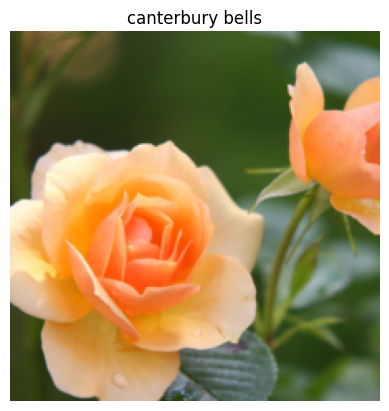

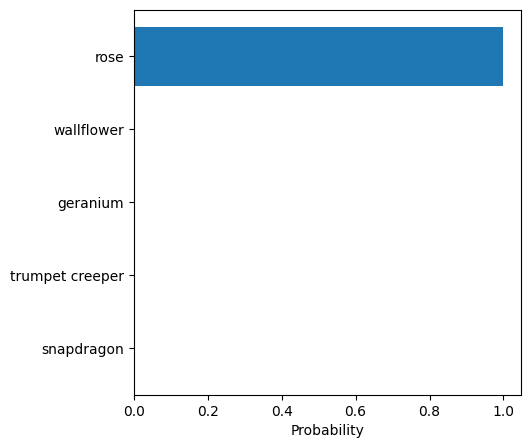

In [ ]:
# Display an image along with the top 5 classes

plt.rcdefaults()
fig, ax = plt.subplots()

index = 3
# path = test_dir + '/3/image_06634.jpg'
path = '/content/drive/MyDrive/Image Classification/rose.jpg'
ps = predict(path, model)
image = process_image(path)

ax1 = imshow(image, ax = plt)
ax1.axis('off')
ax1.title(cat_to_name[str(index)])


a = np.array(ps[0][0])
b = [cat_to_name[str(i)] for i in ps[1]]

fig,ax2 = plt.subplots(figsize=(5,5))


y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(b)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, a)

plt.show()



In [ ]:
# To remove .pth files

# ! rm *.pth